# 18 객체 검출 (One-stage object detection)
- SSD, YOLO

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
# w = !apt install tree
# print(w[-2])

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [2]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [3]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
# 폰트 관련 용도
import matplotlib.font_manager as fm
import cv2

import torch
from torch import nn, optim
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import models, datasets, transforms
from torchinfo import summary

In [4]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [5]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## SSD 모델 사용하기

### 모델 불러 오기

In [6]:
## Pretrained object detection model list
dir(models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [7]:
## load model
# from torchvision.models.detection import ssd300_vgg16 # input image 300x300, backbone vgg16

weights = models.detection.SSD300_VGG16_Weights.COCO_V1 # 2014
ssd300 = models.detection.ssd300_vgg16(weights = weights)
# weights.transforms()


### 모델 확인 하기

In [8]:
print(ssd300)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [9]:
summary(ssd300, (1, 3, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [97, 4]                   --
├─GeneralizedRCNNTransform: 1-1          [1, 3, 300, 300]          --
├─SSDFeatureExtractorVGG: 1-2            [1, 256, 1, 1]            512
│    └─Sequential: 2-1                   [1, 512, 38, 38]          --
│    │    └─Conv2d: 3-1                  [1, 64, 300, 300]         (1,792)
│    │    └─ReLU: 3-2                    [1, 64, 300, 300]         --
│    │    └─Conv2d: 3-3                  [1, 64, 300, 300]         (36,928)
│    │    └─ReLU: 3-4                    [1, 64, 300, 300]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 150, 150]         --
│    │    └─Conv2d: 3-6                  [1, 128, 150, 150]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 150, 150]        --
│    │    └─Conv2d: 3-8                  [1, 128, 150, 150]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 150, 150]     

### 데이터 준비

In [10]:
## Image preprocessing
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# transform = transforms.Compose([
#     transforms.Resize((300, 300)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.48235, 0.45882, 0.40784],  # Mean values for COCO (normalized to [0, 1])
#         std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]  # Scale pixel values to [0, 1]
#     )
# ])

In [11]:
# VOCDetection 데이터셋 불러오기
dataset = datasets.VOCDetection(root = "./VOC_dataset/VOC2012", 
                                year = "2012",
                                image_set = "val", # Use "train", "val", or "trainval"
                                download=True,
                                transform = transform # Apply preprocessing pipeline
                                )  

# data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

Using downloaded and verified file: ./VOC_dataset/VOC2012\VOCtrainval_11-May-2012.tar
Extracting ./VOC_dataset/VOC2012\VOCtrainval_11-May-2012.tar to ./VOC_dataset/VOC2012


### 입력 영상 확인하기

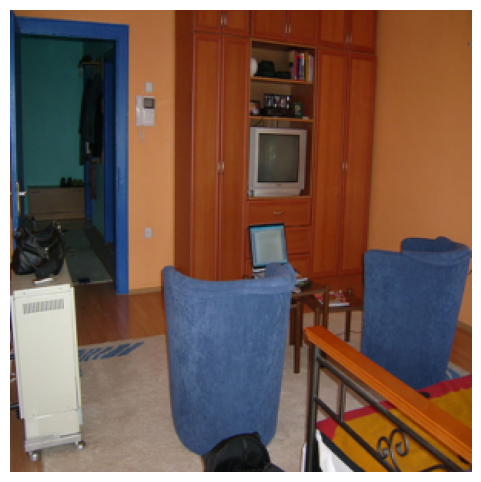

In [13]:
idx = torch.randint(len(dataset), size = (1, ))
image, annotation = dataset[idx.item()]


plt.imshow(image.permute(1, 2, 0))
plt.grid(None)
plt.axis("off")
plt.show()

### 모델 예측

In [14]:
import time

idx = torch.randint(len(dataset), size = (1, ))
image_jpg, annotation = dataset[idx.item()]
image = image_jpg.unsqueeze(0).to(device)

ssd300.eval()
start = time.time()
with torch.no_grad():
    prediction = ssd300(image)
stop = time.time()
print(f"estimation time = {(stop - start)*1000:.3f}ms")
prediction = prediction[0] # batch remove
prediction

estimation time = 185.503ms


{'boxes': tensor([[1.1262e+02, 6.5100e+01, 2.1513e+02, 1.8358e+02],
         [8.8847e+01, 6.2713e+01, 2.4138e+02, 2.5318e+02],
         [8.2444e+00, 1.4865e+02, 2.9779e+02, 2.9904e+02],
         [2.4332e+02, 3.4011e+00, 2.9987e+02, 1.3884e+02],
         [1.8608e+01, 2.8053e+01, 6.6836e+01, 2.1345e+02],
         [6.5991e+00, 1.7761e+02, 1.5280e+02, 2.9850e+02],
         [1.1509e+02, 6.3359e+01, 1.7068e+02, 1.6076e+02],
         [1.5691e+02, 8.5306e+01, 2.3508e+02, 1.8724e+02],
         [7.1447e+01, 7.7665e+01, 1.6359e+02, 2.0069e+02],
         [2.5747e+02, 3.0218e+01, 2.9824e+02, 8.5727e+01],
         [2.4039e+01, 2.4206e+02, 5.2521e+01, 2.7752e+02],
         [2.7608e+01, 2.5449e+02, 4.7232e+01, 2.7788e+02],
         [1.2059e+02, 1.0803e+02, 1.5563e+02, 1.8187e+02],
         [1.4902e+02, 1.0802e+02, 1.9267e+02, 1.8077e+02],
         [1.3566e+01, 5.9837e+01, 2.9061e+02, 2.9515e+02],
         [1.3296e+02, 1.4723e+02, 2.0539e+02, 1.8141e+02],
         [1.2713e+02, 1.3802e+02, 2.1133e+02, 2

### Bounding box 그리기

[112, 65, 215, 183]


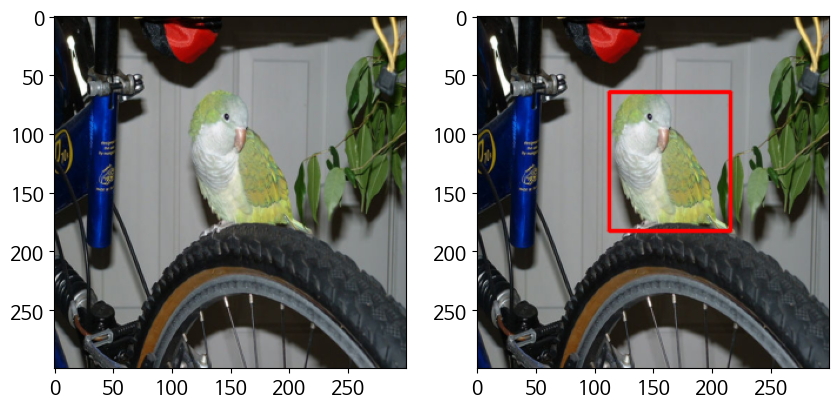

In [15]:

image = image.cpu().data[0]
image = transforms.functional.to_pil_image(image)
image = np.array(image)

threshold=0.5

for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
    if score > threshold:
        box = list(map(int, box))
        print(box)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2, cv2.LINE_AA)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].imshow(image_jpg.permute(1, 2, 0))
axs[0].grid(None)
axs[1].imshow(image)
axs[1].grid(None)
plt.show()


## SSD + CV DNN 얼굴검출
- https://github.com/spmallick/learnopencv/tree/master/AgeGender

In [32]:
import numpy as np
import sys
import cv2
import pandas as pd
img = cv2.imread('./figure/king_face.png')

if img is None:
    print('image read failed')
    sys.exit()

## tensorflow model   
model = './opencv_face_detector/opencv_face_detector_uint8.pb'
config = './opencv_face_detector/opencv_face_detector.pbtxt'

face_net = cv2.dnn.readNet(model, config)
# face_net.getLayerNames()

if face_net.empty():
    print('Net open failed')
    sys.exit()

# blobFromImage(image[, scalefactor[, size[, mean[, swapRB[, crop[, ddepth]]]]]]) -> retval
blob = cv2.dnn.blobFromImage(img, 1, (300, 300), (104, 177, 123),
                            swapRB=False)

face_net.setInput(blob)
out = face_net.forward()

labels = ["img_id", "is_face", "confidence", "left", "top", "right", "bottom"]
out_df = pd.DataFrame(out[0][0], columns = labels)
print(out_df)


     img_id  is_face  confidence      left       top     right    bottom
0       0.0      1.0    0.989431  0.825202  0.502988  0.893821  0.658601
1       0.0      1.0    0.950553  0.147596  0.511079  0.215222  0.681570
2       0.0      1.0    0.947276  0.288199  0.444965  0.359195  0.628823
3       0.0      1.0    0.920967  0.499137  0.392986  0.589955  0.570557
4       0.0      1.0    0.835135  0.642767  0.463616  0.720524  0.659535
..      ...      ...         ...       ...       ...       ...       ...
195     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
196     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
197     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
198     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000
199     0.0      0.0    0.000000  0.000000  0.000000  0.000000  0.000000

[200 rows x 7 columns]


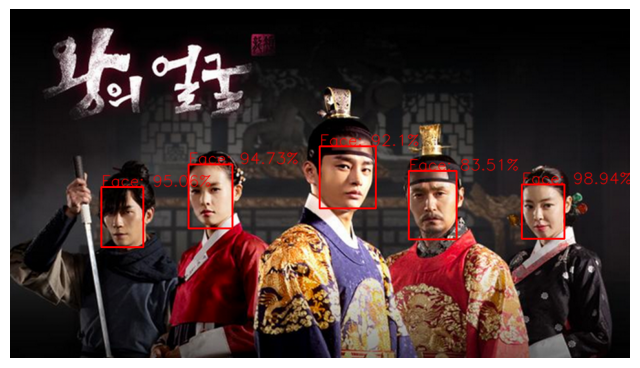

In [33]:

detect = out[0, 0, :, :]
h, w = img.shape[:2]

for i in range(detect.shape[0]):
    confidence = detect[i, 2] # (0, 1, confidence, x1, y1, x2, y2)
    
    if confidence > 0.15:
        # out matrix에서 x1, y1, x2, y2 값이 0 ~1로 normalize 되어 있음
        
        x1 = int(detect[i, 3]*w)
        y1 = int(detect[i, 4]*h)
        x2 = int(detect[i, 5]*w)
        y2 = int(detect[i, 6]*h)
        
        cv2.rectangle(img, (x1, y1), (x2, y2),
                     (0, 0, 255), 2)
        
        text = 'Face: {}%'.format(round(confidence*100, 2))
        cv2.putText(img, text, (x1, y1-1), cv2.FONT_HERSHEY_SIMPLEX,
                   0.8, (0, 0, 255), 1, cv2.LINE_AA)
        
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (8,8))
plt.imshow(img)
plt.grid(None)
plt.axis("off")
plt.show()

## Yolo v3 객체검출 with opencv dnn

In [ ]:
# https://pjreddie.com/darknet/yolo/

# NMSBoxes(bboxes, scores, score_threshold, nms_threshold) -> indices
# nms_threshold: nms_threshold a threshold used in non maximum suppression

# getPerfProfile() -> retval, timings
# .   @brief Returns overall time for inference and timings (in ticks) for layers.

# https://github.com/pjreddie/darknet/blob/master/data/coco.names

In [35]:
## Automating with K-Means in Python

import numpy as np
from sklearn.cluster import KMeans

# Example bounding boxes (width, height)
bboxes = np.array([[32, 32], [64, 64], 
                   [128, 128], [256, 256], 
                   [512, 512], [128, 64], 
                   [64, 128], [256, 128]])

# Perform K-means clustering with k=9
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(bboxes)

# Output anchor boxes
anchors = kmeans.cluster_centers_
print("Anchors:", anchors)


Anchors: [[512.  512. ]
 [ 83.2  83.2]
 [256.  192. ]]


In [ ]:
import sys
import numpy as np
import cv2

# 모델 & 설정 파일
model = './yolo_v3_pb/yolov3.weights'
config = './yolo_v3_pb/yolov3.cfg'
class_labels = './yolo_v3_pb/coco.names'

# 테스트 이미지 파일
img_files = ['./figure/dog.jpg', 
             './figure/person.jpg', 
             './figure/sheep.jpg', 
             './figure/kite.jpg']


# 네트워크 생성
net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

# 클래스 이름 불러오기
classes = []
with open(class_labels, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# colors = np.random.uniform(0, 255, size=(len(classes), 3))
# colors = np.array([[0, 0, 255], 
#                    [255, 0, 0],
#                    [0, 255, 0],
#                    [0, 255, 255],
#                    [255, 255, 0],
#                    [255, 0, 255]])

# 출력 레이어 이름 받아오기
net.getUnconnectedOutLayers()
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
print(output_layers)

['yolo_82', 'yolo_94', 'yolo_106']


['./figure/dog.jpg', './figure/person.jpg', './figure/sheep.jpg', './figure/kite.jpg']


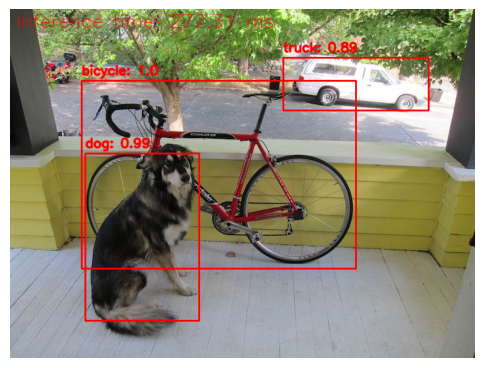

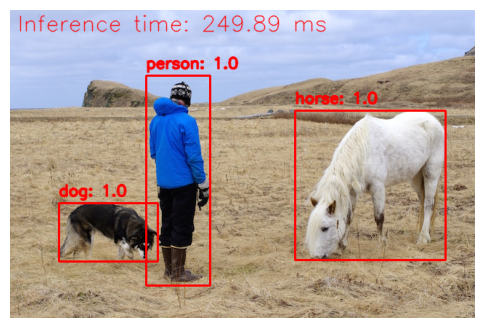

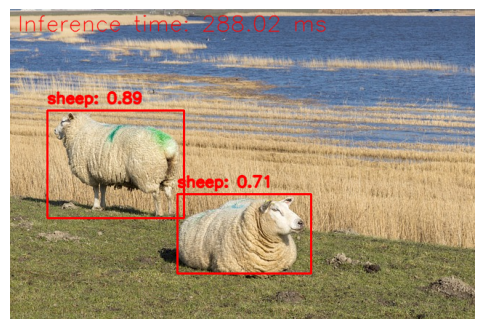

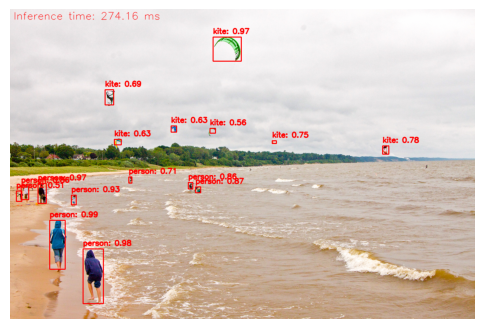

In [66]:
# outs는 3개의 ndarray 리스트.
# output_layers = ['yolo_82', 'yolo_94', 'yolo_106']
# output_layers[0].shape = (507, 85), 13*13*3
# output_layers[1].shape = (2028, 85), 26*26*3
# output_layers[2].shape = (8112, 85), 52*52*3
import time

confThreshold = 0.5
nmsThreshold = 0.4

# 실행
print(img_files)
for i in img_files:
    img = cv2.imread(i)

    if img is None:
        continue

    # 블롭 생성 & 추론
    blob = cv2.dnn.blobFromImage(img, 1/255., (320, 320), swapRB=True)
    # blob = cv2.dnn.blobFromImage(img, 1/255., (416, 416), swapRB=True)
    # blob = cv2.dnn.blobFromImage(img, 1/255., (608, 608), swapRB=True)

    net.setInput(blob)
    outs = net.forward(output_layers) 

    # outs[0].shape=(507, 85), 13*13*3=507
    # outs[1].shape=(2028, 85), 26*26*3=2028
    # outs[2].shape=(8112, 85), 52*52*3=8112

    h, w = img.shape[:2]

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            # detection: 4(bounding box) + 1(objectness_score) + 80(class confidence)
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confThreshold:
                # 바운딩 박스 중심 좌표 & 박스 크기
                cx = int(detection[0] * w)
                cy = int(detection[1] * h)
                bw = int(detection[2] * w)
                bh = int(detection[3] * h)

                # 바운딩 박스 좌상단 좌표
                sx = int(cx - bw / 2)
                sy = int(cy - bh / 2)

                boxes.append([sx, sy, bw, bh])
                confidences.append(float(confidence))
                class_ids.append(int(class_id))

    # 비최대 억제, Non Max Suppression
# https://deep-learning-study.tistory.com/403
# nmsThreshold: Determines the IoU (Intersection over Union) threshold
# A higher value results in more boxes being retained.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)

    for i in indices:
#         i = i[0]
        sx, sy, bw, bh = boxes[i]
        label = f'{classes[class_ids[i]]}: {confidences[i]:.2}'
        # color = colors[class_ids[i]]
        color = (0, 0, 255)
        cv2.rectangle(img, (sx, sy, bw, bh), color, 2)
        cv2.putText(img, label, (sx, sy - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

    t, _ = net.getPerfProfile() # Total number of ticks spent during the last forward() call.
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 1, cv2.LINE_AA)
    
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.grid(None)
    plt.axis("off")
    plt.show()

## Yolo v10 객체검출 with pytorch

In [ ]:
!pip install ultralytics

In [69]:
from ultralytics import YOLO

In [68]:
## coco dataset
# 클래스 이름 불러오기
# classNames = []
with open(class_labels, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')

# classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
#               "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
#               "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
#               "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
#               "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
#               "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
#               "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
#               "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
#               "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
#               "teddy bear", "hair drier", "toothbrush"
#               ]

estimation time = 701.129ms


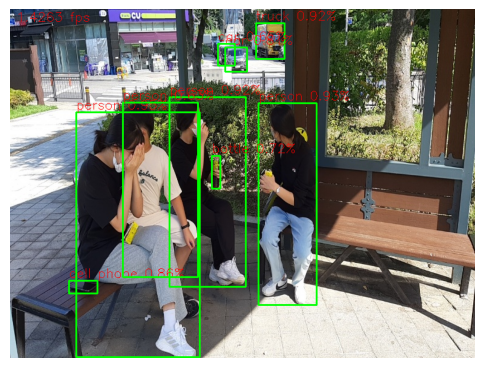

In [85]:
import time

data_dir = "./figure"

img_path = os.path.join(data_dir, "peoples.jpg")
img = cv2.imread(img_path)

if img is None:
    print("Image read failed")
    sys.exit()

model = YOLO("yolo11x.pt")  # load a pretrained model (recommended for training)

start = time.time()
detection = model(img, verbose=False)[0]
stop = time.time()
on_time = (stop - start)*1000
print(f"estimation time = {on_time:.3f}ms")
fps = f'{1000 / on_time:.4f} fps'
CONFIDENCE_THRESHOLD = 0.6

for data in detection.boxes.data.tolist():
        confidence = data[4]
        if confidence < CONFIDENCE_THRESHOLD:
            continue
        
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        label = int(data[5])
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(img, classNames[label]+ ' ' +str(round(confidence, 2))+'%', 
        (xmin, ymin-5), cv2.FONT_ITALIC, 0.7, (0, 0, 255), 1)        

    
        cv2.putText(img, fps, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)


img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.grid(None)
plt.axis("off")
plt.show()